<div style="text-align: center;">
  <img src="images/op.webp" alt="OP" width="25%">
</div>

Grupo:
- Daniel Nobre de Queiroz Pereira
- Georg Herison Maia Nunes
- Yves Pablo Costa Rêgo

# Atividade Avaliativa Unidade 1

**Descrição:**
Neste notebook, vamos construir o pipeline de PLN para análise de sentimento dos arcos de One Piece utilizando um dataset em **inglês**. Cobriremos desde a coleta e organização dos textos dos capítulos, até o pré-processamento e extração de features. A modelagem e avaliação dos modelos ficarão para a Atividade 2.

**Objetivos da Atividade 1:**
1. Coletar e organizar os datasets (textos dos capítulos em inglês).  
2. Executar limpeza e pré-processamento (tokenização, remoção de stopwords, normalização) adaptados para inglês.  
3. Extrair features (Bag-of-Words, TF–IDF).  
4. Realizar Análise Exploratória de Dados (EDA) e conclusões iniciais.

## Coleta e organização do dataset

O dataset utilizado foi coletado utilizando OCR para extrair o texto dos capítulos do mangá. Inicialmente, apenas os 100 primeiros capítulos (cerca de 10% do total) foram utilizados.


Os dados foram organizados da seguinte forma:

```
One_Piece/
├── Chapter 1 Romance Dawn - The Dawn of the Adventure _July 19 1997_ 53/
│   └── texts/
│       ├── 01.txt
│       ├── 02.txt
│       ├── 03.txt
│       └── ...
├── Chapter 2 That Guy, "Straw Hat Luffy" _August 4 1997_ 45/
│   └── texts/
│       ├── 01.txt
│       ├── 02.txt
│       ├── 03.txt
│       └── ...
└── ...
```
Com 01.txt, 02.txt [...] representando o texto contido em uma página do capítulo.

## 1. Setup do ambiente

Nesta seção, importamos as bibliotecas necessárias e configuramos o ambiente para rodar nosso pipeline.

In [8]:
# Bibliotecas para manipulação de dados e texto
import os
import re
import pandas as pd
import numpy as np

# Biblioteca de tokenização e stopwords
import nltk


# Biblioteca para extração de features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Para visualizações iniciais
import matplotlib.pyplot as plt

# Garantir downloads de recursos NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Georg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Georg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Georg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## 2. Carregar Dados

Carregamos todos os arquivos de texto dos capítulos em um DataFrame.

In [50]:
import os
import re
import pandas as pd

# Caminho para o diretório base
base_path = 'One_Piece'

# Listas para armazenar dados
arcos = []
capitulos = []
nomes_arquivos = []
conteudos = []

# Percorrer todos os diretórios e subdiretórios
for root, dirs, files in os.walk(base_path):
    if 'texts' in dirs:
        texts_path = os.path.join(root, 'texts')
        
        for txt_file in sorted(os.listdir(texts_path)):
            if txt_file.endswith('.txt'):
                file_path = os.path.join(texts_path, txt_file)
                
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read().replace('\n', ' ').strip()
                
                # Limpeza de conteúdo
                content = re.sub(r'https?://\S+', '', content)  # Remove URLs
                content = re.sub(r'\b(?:mangare|renet)[\w\.-]*', '', content)  # Remove palavras tipo 'mangareader.net'
                content = re.sub(r'\.(com|net|org|xyz|br)\b', '', content)  # Remove domínios isolados
                content = re.sub(r'\s+', ' ', content).strip()

                # Pegar nome do arco e do capítulo
                arc_name = os.path.basename(os.path.dirname(root))  # pasta acima de texts
                chapter_name = os.path.basename(root)  # pasta que contém 'texts'

                # Armazenar dados
                arcos.append(arc_name)
                capitulos.append(chapter_name)
                nomes_arquivos.append(txt_file)
                conteudos.append(content)

# Criar o DataFrame
df = pd.DataFrame({
    'arc': arcos,
    'chapter': capitulos,
    'file': nomes_arquivos,
    'text': conteudos
})

print(df.head())



               arc                                            chapter    file  \
0  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  01.txt   
1  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  02.txt   
2  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  03.txt   
3  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  04.txt   
4  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  05.txt   

                                                text  
0  ONEPIECE AB EHCHIRO ODA ROMANCE DAWN- JUMP COM...  
1  ROMANCE DAWN ElICHIRO ODA JUMP COMICS ONEPIECE...  
2  CHAPTER7"FRIEND' CHAPTER6FIRST PERSON CHAPTER8...  
3  HIS LAST WORDS BEFORE HIS EXECUTION HAVE INSPI...  
4  MAGES EDITTED BY AOSH TRANSLATION BY JIN-ROH A...  


## 3. Pré-processamento

Limpeza básica do texto em inglês: minúsculas, remoção de pontuação/números, tokenização e remoção de stopwords.

In [51]:
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
# stopwords = set(stopwords_list.decode().splitlines()) 

def preprocess(text):
    # minusculas
    text = text.lower()
    # deixa apenas letras
    text = re.sub(r"[^a-z\s]", "", text)
    # tokenizacao
    tokens = word_tokenize(text, language='english')
    ## stopwords da library
    #sw = set(stopwords.words('english'))
    ## stopwords com mais palavras
    sw = set(stopwords_list.decode().splitlines()) 
    
    # outras stopwords pra limpar
    extra_stopwords = {'onepiecg', 'oda', 'isbnc', 'eiichiro', 'nbn', 'sbs', 'japan'} 
    sw.update(extra_stopwords)
    tokens = [t for t in tokens if t not in sw and len(t) > 1]
    return tokens

df['tokens'] = df['text'].apply(preprocess)
df[['chapter', 'tokens']]

,chapter,tokens
0,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[onepiece, ehchiro, romance, dawn, jump, comic..."
1,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[romance, dawn, elichiro, jump, comics, onepie..."
2,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[chapterfriend, chapterfirst, person, chaptern..."
3,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[execution, inspired, pirates, entered, pirate..."
4,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[mages, editted, aosh, translation, jinroh, ao..."
...,...,...
19438,Chapter 999 The Sake I Brewed to Drink With Yo...,"[charging, complete, idont, care, killbut, lea..."
19439,Chapter 999 The Sake I Brewed to Drink With Yo...,"[stil, asa, brother, owe, life, long, debt, ka..."
19440,Chapter 999 The Sake I Brewed to Drink With Yo...,"[patreonpatreontcbscans, readers, weare, magaz..."
19441,Chapter 999 The Sake I Brewed to Drink With Yo...,"[kaidos, tattoo, lives, island, atop, gigantic..."


## 4. Extração de Features

Criamos representações Bag-of-Words e TF–IDF.

In [52]:
df['clean_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(df['clean_text'])
print(f"Bag-of-Words shape: {X_counts.shape}")

tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(df['clean_text'])
print(f"TF–IDF shape: {X_tfidf.shape}")

Bag-of-Words shape: (19443, 105354)
TF–IDF shape: (19443, 105354)


## 5. Análise Exploratória de Dados (EDA)

### 5.1 Tamanho dos textos (número de palavras)








In [12]:
df['text_length'] = df['tokens'].apply(len)

### Estatísticas descritivas

In [69]:
print(df['text_length'].describe())


count    2141.000000
mean       21.075199
std        15.365894
min         0.000000
25%        10.000000
50%        19.000000
75%        29.000000
max       121.000000
Name: text_length, dtype: float64


### Histograma da distribuição do tamanho dos textos

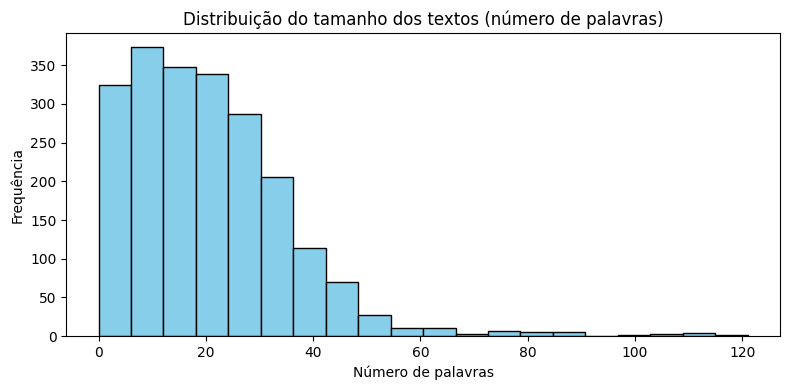

In [70]:
plt.figure(figsize=(8, 4))
plt.hist(df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição do tamanho dos textos (número de palavras)')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

### 📊 Análise Univariada

**Distribuição do Tamanho dos Textos**

O histograma da distribuição do número de palavras por trecho mostra que a maioria dos textos possui entre 5 e 30 palavras. Há um pico de frequência entre 20 e 25 palavras, o que sugere que esse é o tamanho mais comum dos trechos extraídos. O formato assimétrico à direita (distribuição enviesada positivamente) indica que há poucos textos com um número muito alto de palavras, possivelmente resultantes de páginas com maior densidade de diálogos ou descrições.

### 📌 Estatísticas descritivas relevantes:

Média de palavras por trecho: entre 20 e 25

Desvio padrão estimado: relativamente moderado

Assimetria positiva: cauda mais longa à direita

### 5.2 Número de palavras únicas por capítulo

In [13]:
df['unique_words'] = df['tokens'].apply(lambda x: len(set(x)))

### Dispersão: tamanho do texto vs. palavras únicas

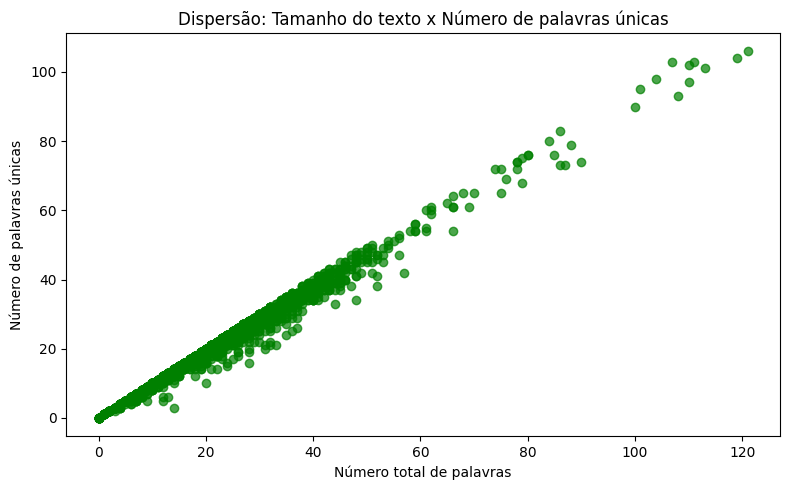

In [72]:
plt.figure(figsize=(8, 5))
plt.scatter(df['text_length'], df['unique_words'], alpha=0.7, color='green')
plt.title('Dispersão: Tamanho do texto x Número de palavras únicas')
plt.xlabel('Número total de palavras')
plt.ylabel('Número de palavras únicas')
plt.tight_layout()
plt.show()

### Correlação

In [73]:
correlation = df[['text_length', 'unique_words']].corr()
print("Correlação entre tamanho do texto e número de palavras únicas:")
print(correlation)

Correlação entre tamanho do texto e número de palavras únicas:
              text_length  unique_words
text_length      1.000000      0.993632
unique_words     0.993632      1.000000


### 🔍 Análise Bivariada

**Relação entre Número Total de Palavras e Palavras Únicas**

O gráfico de dispersão mostra uma relação fortemente linear entre o número total de palavras e o número de palavras únicas por texto. Isso indica que, conforme o tamanho do texto aumenta, há um crescimento proporcional na diversidade lexical (riqueza de vocabulário).

No entanto, observa-se que essa diversidade tende a se estabilizar levemente em textos maiores, sugerindo repetição de termos comuns em falas mais longas.

### 📌 Interpretação:

- Correlação positiva forte (visual) entre comprimento e diversidade de palavras.

- Textos curtos apresentam pouca diversidade, como esperado.

- Textos com mais de 50 palavras não aumentam proporcionalmente a quantidade de palavras únicas, indicando possível redundância lexical.

### 5.3 Termos mais frequentes

In [74]:
freq = np.array(X_counts.sum(axis=0)).flatten()
terms = count_vec.get_feature_names_out()
freq_df = pd.DataFrame({'term': terms, 'frequency': freq})
freq_df = freq_df.sort_values(by='frequency', ascending=False).head(20)

freq_df

,term,frequency
3112,dont,331
10084,pirate,304
10047,piece,298
10094,pirates,242
1824,captain,232
1975,chapter,210
14537,village,194
6099,ill,189
11652,ship,163
2665,damn,160


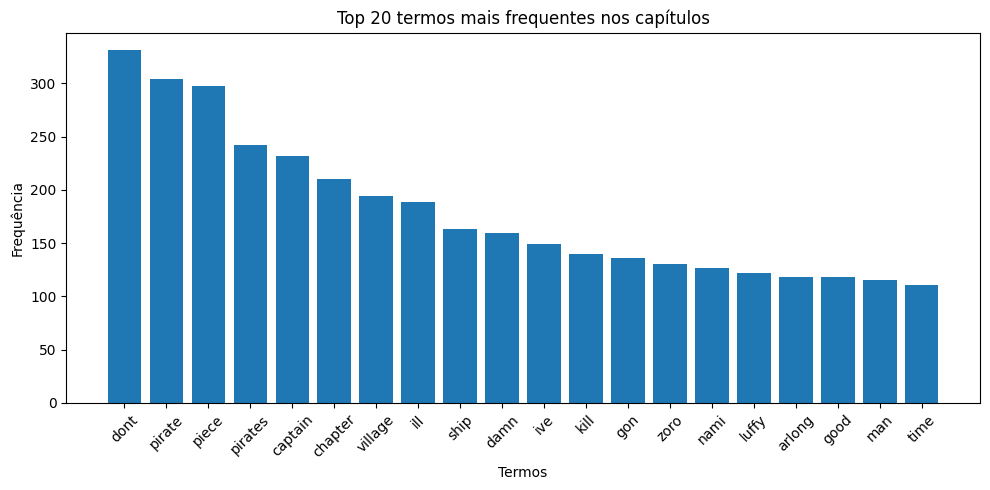

In [75]:
plt.figure(figsize=(10,5))
plt.bar(freq_df['term'], freq_df['frequency'])
plt.xticks(rotation=45)
plt.title('Top 20 termos mais frequentes nos capítulos')
plt.ylabel('Frequência')
plt.xlabel('Termos')
plt.tight_layout()
plt.show()

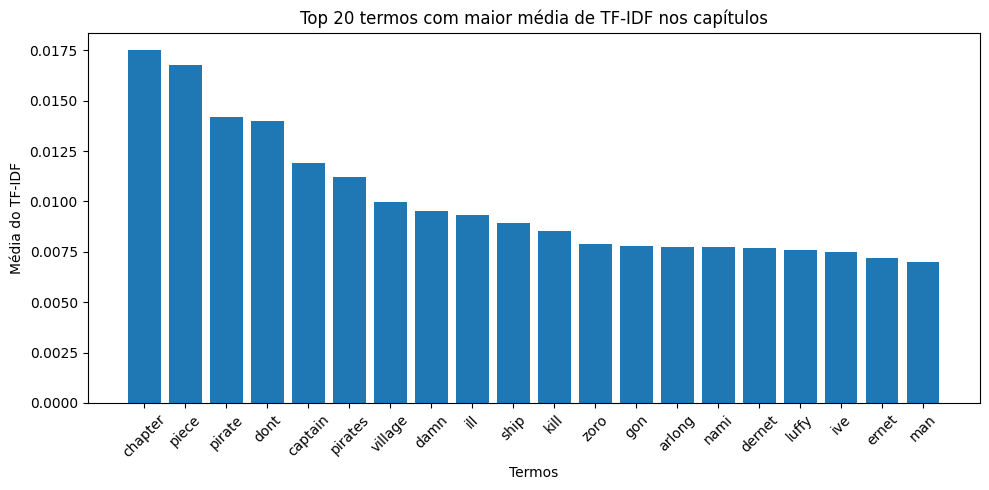

In [76]:
# Calcular média do TF-IDF por termo
tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()
terms_tfidf = tfidf_vec.get_feature_names_out()

# Criar DataFrame com os termos e suas médias de TF-IDF
tfidf_df = pd.DataFrame({'term': terms_tfidf, 'tfidf': tfidf_means})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# Visualização
plt.figure(figsize=(10, 5))
plt.bar(tfidf_df['term'], tfidf_df['tfidf'])
plt.xticks(rotation=45)
plt.title('Top 20 termos com maior média de TF-IDF nos capítulos')
plt.ylabel('Média do TF-IDF')
plt.xlabel('Termos')
plt.tight_layout()
plt.show()


# Conclusões iniciais e interpretação preliminar
Em nossa análise inicial, após o pré-processamento, observamos que nomes de personagens e expressões em inglês características do mangá aparecem entre os mais frequentes.

Além disso, analisamos a frequência de palavras em 4 situações:
1. **Sem remoção de stopwords**  
   ![Gráfico sem remoção de stopwords](images/no_stopwords.jpeg)  
   As palavras mais frequentes eram comuns ao inglês — *"you"*, *"the"*, *"that"*.

2. **Com remoção de stopwords usando NLTK**  
   ![Gráfico com stopwords padrão do NLTK](images/default_stopwords.jpeg)  
   Começaram a aparecer termos mais relacionados ao conteúdo, como *"pirates"* e *"captain"*.

3. **Com remoção de mais stopwords (lista do GitHub)**  
   ![Gráfico com lista estendida de stopwords](images/more_stopwords.jpeg)  
   Os termos estavam mais ligados ao domínio, mostrando nomes de personagens (*"Zoro"*, *"Luffy"*, *"Nami"*) e reduzindo palavras erroneamente escritas em inglês.

4. **Com stopwords do GitHub + remoções customizadas**  
   ![Gráfico com lista estendida de stopwords](images/4.png)  
   Os termos ficaram mais limpos com a inclusão de algumas palavras-chave como stopwords (como "onepieceg").

Apesar disso, nota-se que as stopwords incluem termos como "not" e "don't", que podem alterar o significado das frases.


Os achados sugerem que a linguagem utilizada nos capítulos segue uma estrutura repetitiva com vocabulário limitado em trechos curtos (condizente com balões de fala). A proporção de palavras únicas aumenta inicialmente, mas tende a estabilizar à medida que o tamanho do texto cresce, o que é comum em narrativas com linguagem informal ou diálogo intenso.

Essas observações abrem espaço para futuras análises, como:

- Detecção de personagens pela frequência de termos específicos.

- Evolução do vocabulário ao longo dos capítulos.


Na próxima etapa, segmentaremos por arcos (ex.: capítulos 1–61 para East Blue) e exploraremos a rotulação.

---
**Próximos passos (Atividade 2):**
- Definir rótulos de sentimento
- Treinar modelos de classificação de sentimento
- Avaliar e comparar resultados entre os arcos narrativos

Teste

In [56]:
print(df.head())

               arc                                            chapter    file  \
0  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  01.txt   
1  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  02.txt   
2  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  03.txt   
3  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  04.txt   
4  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  05.txt   

                                                text  \
0  ONEPIECE AB EHCHIRO ODA ROMANCE DAWN- JUMP COM...   
1  ROMANCE DAWN ElICHIRO ODA JUMP COMICS ONEPIECE...   
2  CHAPTER7"FRIEND' CHAPTER6FIRST PERSON CHAPTER8...   
3  HIS LAST WORDS BEFORE HIS EXECUTION HAVE INSPI...   
4  MAGES EDITTED BY AOSH TRANSLATION BY JIN-ROH A...   

                                              tokens  \
0  [onepiece, ehchiro, romance, dawn, jump, comic...   
1  [romance, dawn, elichiro, jump, comics, onepie...   
2  [chap

In [70]:
from transformers import pipeline
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np

# Pipeline de emoções
device = 0 if torch.cuda.is_available() else -1
emotion_pipeline = pipeline("text-classification", 
                            model="bhadresh-savani/bert-base-uncased-emotion", 
                            return_all_scores=True, 
                            device=device)

# Filtra para pegar só os capítulos do primeiro arco
primeiro_arco = df['arc'].iloc[0]  # Pega o nome do primeiro arco
# Filtra o dataframe para pegar só o primeiro arco inteiro
df_primeiro_arco = df[df['arc'] == df['arc'].unique()[0]]

# Função auxiliar para dividir o texto
def split_text(text, max_length=512):
    return [text[i:i+max_length] for i in range(0, len(text), max_length)]

# Análise por capítulo do arco inteiro (sem limitar a 70)
emotion_results = []


for idx, row in tqdm(df_primeiro_arco.iterrows(), total=len(df_primeiro_arco), desc="Analisando emoções por capítulo"):
    pages = split_text(row['clean_text'])  # Dividir texto em blocos
    all_scores = []

    for page in pages:
        scores = emotion_pipeline(page)
        emotion_scores = {item['label']: item['score'] for item in scores[0]}
        all_scores.append(emotion_scores)

    # Calcula média das emoções por capítulo
    avg_scores = pd.DataFrame(all_scores).mean().to_dict()
    emotion_results.append(avg_scores)

# DataFrame com emoções agregadas por capítulo do arco inteiro
emotion_df = pd.DataFrame(emotion_results)
df_emotion = pd.concat([df_primeiro_arco[['arc', 'chapter']], emotion_df], axis=1)


Device set to use cpu
C:\Users\Georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Número de capítulos no dataframe original: 19443
Capítulos únicos no dataframe original: 1046
Arcos únicos: ['01 Romance Dawn' '02 Orange Town' '03 Syrup Village' '04 Baratie'
 '05 Arlong Park' '06 Loguetown' '07 Reverse Mountain' '08 Whisky Peak'
 '09 Little Garden' '10 Drum Island' '11 Alabasta' '12 Jaya' '13 Skypiea'
 '14 Long Ring Long Land' '15 Water 7' '16 Enies Lobby'
 '17 Post-Enies Lobby' '18 Thriller Bark' '19 Sabaody Archipelago'
 '20 Amazon Lily' '21 Impel Down' '22 Marineford' '23 Post-War'
 '24 Return to Sabaody' '25 Fishman Island' '26 Punk Hazard'
 '27 Dressrosa' '28 Reverie' '29 Zou' '30 Whole Cake Island' '31 Wano']
Número de capítulos no primeiro arco filtrado: 181
Capítulos únicos no primeiro arco: 7
                 arc                                            chapter
0    01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...
1    01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...
2    01 Romance Dawn  Chapter 1 Romance Dawn - The Daw

Analisando emoções por capítulo: 100%|██████████| 181/181 [00:07<00:00, 25.09it/s]


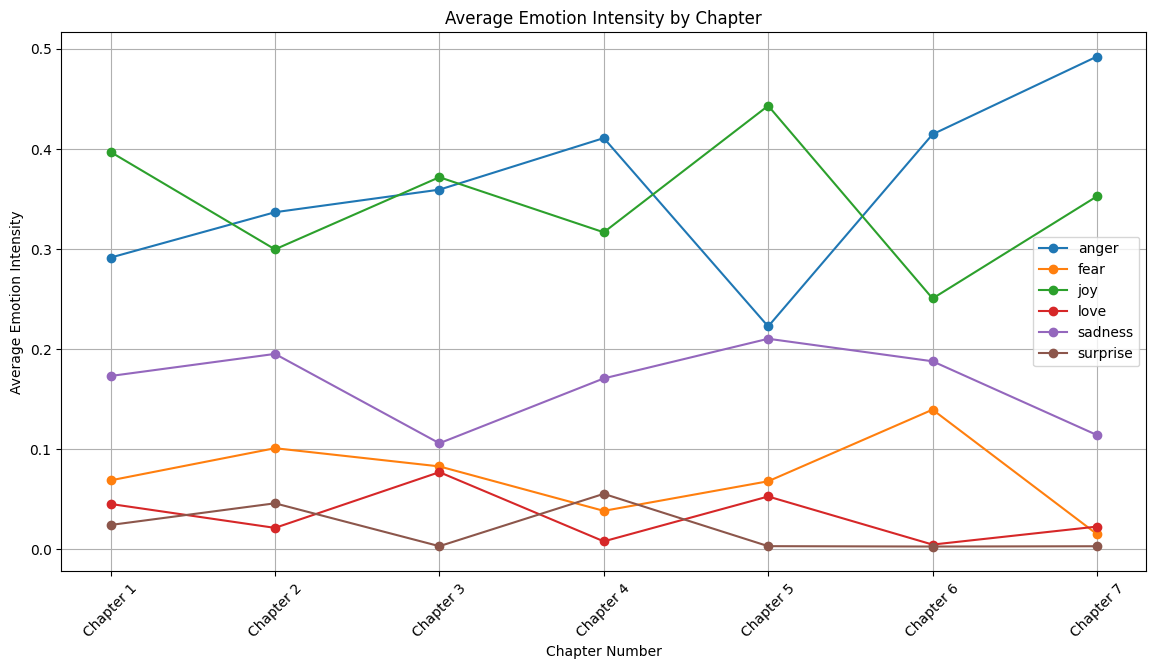

In [72]:
import matplotlib.pyplot as plt

# Assumindo que seu df_emotion tem as colunas: ['chapter', 'arc', 'anger', 'joy', 'sadness', ...]

# 1. Agrupar por capítulo e calcular a média das emoções
emotion_labels = df_emotion.columns.difference(['chapter', 'arc'])
df_grouped = df_emotion.groupby('chapter')[emotion_labels].mean().reset_index()

plt.figure(figsize=(14,7))

# 2. Plotar as emoções médias por capítulo
for emotion in emotion_labels:
    plt.plot(df_grouped['chapter'], df_grouped[emotion], marker='o', label=emotion)

plt.xlabel('Chapter Number')
plt.ylabel('Average Emotion Intensity')
plt.title('Average Emotion Intensity by Chapter')
plt.legend()
plt.grid(True)

# Se quiser formatar o eixo x para mostrar só o número do capítulo, sem strings longas:
chapter_nums = [ch.split(' ')[1] if len(ch.split(' ')) > 1 else ch for ch in df_grouped['chapter']]
labels = [f'Chapter {num}' for num in chapter_nums]

plt.xticks(df_grouped['chapter'], labels, rotation=45)

plt.show()



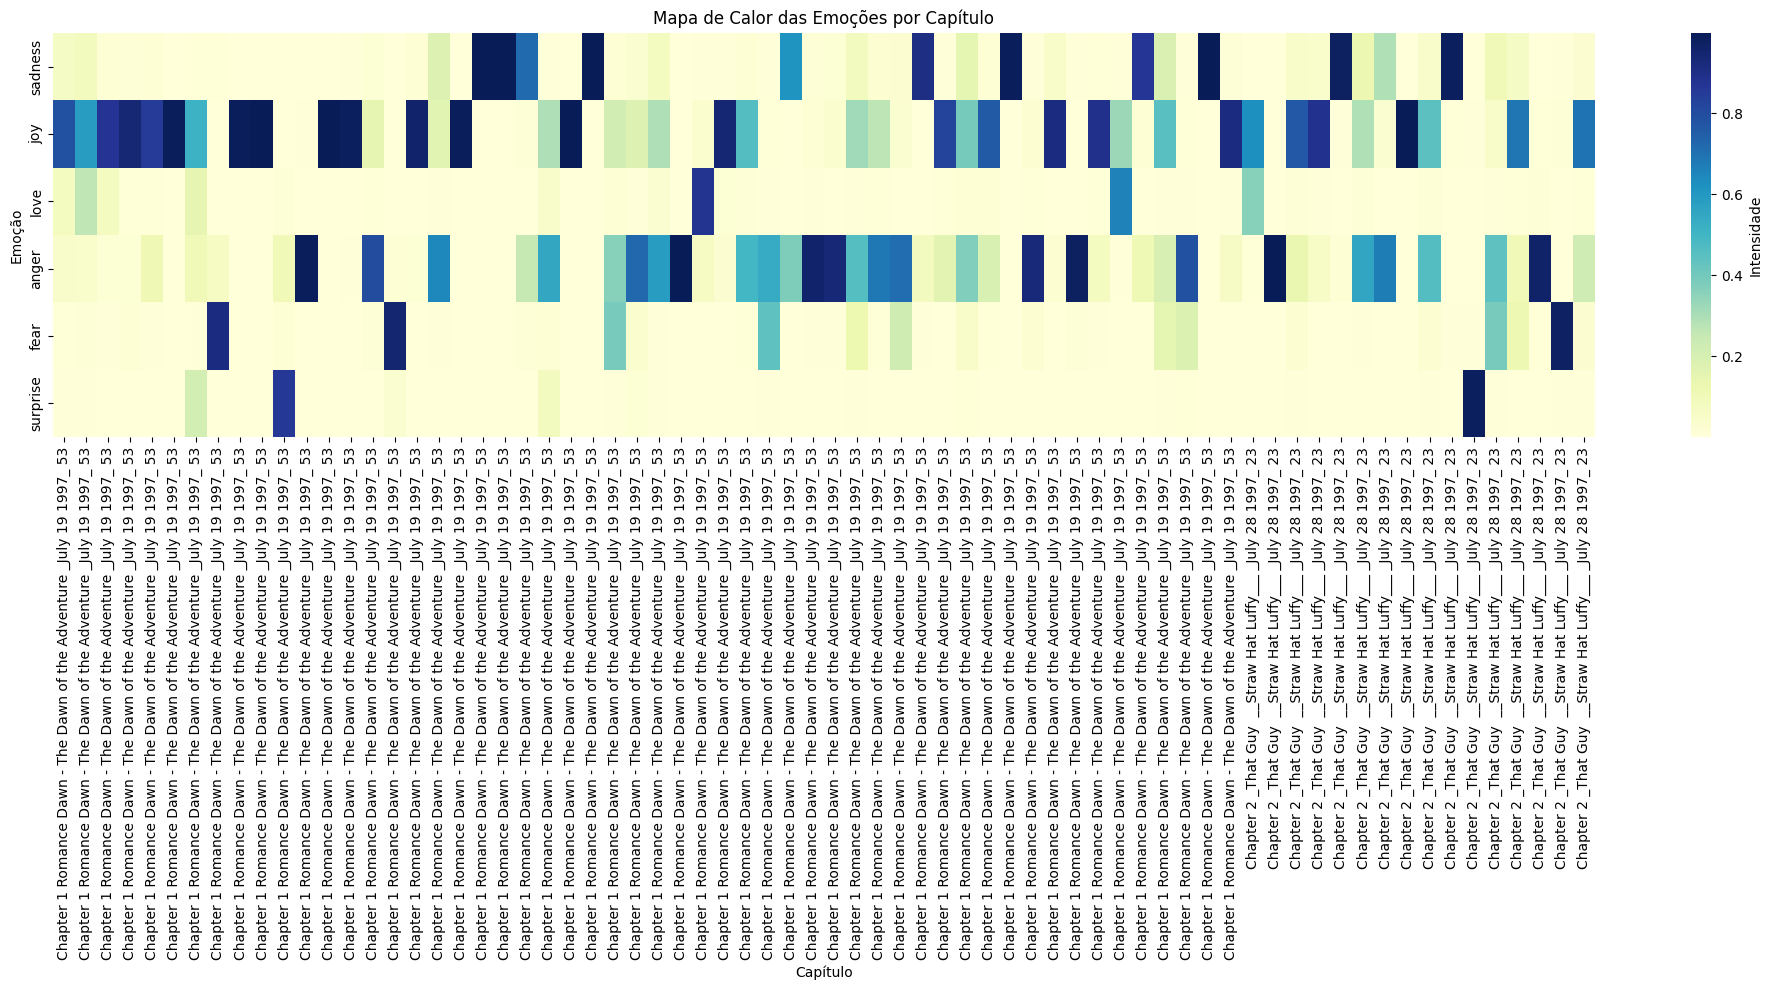

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapa de calor (Heatmap)
plt.figure(figsize=(20, 10))
sns.heatmap(
    emotion_df.T,  # transposta para emoções nas linhas
    cmap="YlGnBu", 
    cbar_kws={'label': 'Intensidade'},
    xticklabels=df_emotion['chapter'].values
)

plt.title("Mapa de Calor das Emoções por Capítulo")
plt.xlabel("Capítulo")
plt.ylabel("Emoção")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


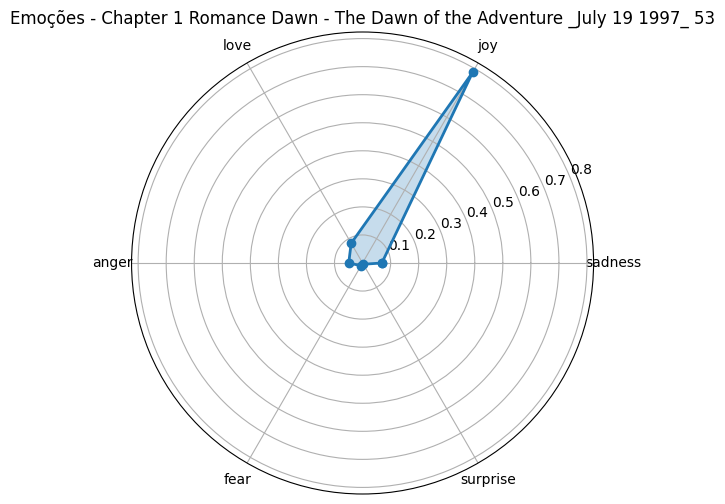

In [26]:
import numpy as np

def plot_radar(emotion_row, chapter_name):
    labels = list(emotion_row.index)
    stats = emotion_row.values

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    stats = np.concatenate((stats, [stats[0]]))
    angles += [angles[0]]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f"Emoções - {chapter_name}")
    ax.grid(True)
    plt.show()

# Exemplo: capítulo 0
plot_radar(emotion_df.iloc[0], df_emotion['chapter'].iloc[0])
